# ADA Project : Milestone 3

## Cracking the Hollywood interview

On average, the production of a major box office movie costs $65 million, without counting the marketing and distribution fees. Unlike house construction, which usually ends up exactly like the pre-sketched plan, making a movie is unpredictable and anticipating the audience’s opinion is nearly impossible despite the effort and money spent.
Thus, producing it the right way is a crucial job that requires long-time studies and decision-making about the relevant parts that define the movie. This includes the storyline, the script, the actors, the budget, and many more.
This motivates our goal of studying the successful as well as failed films in terms of public ratings collected through the IMDB databases as well as the box office revenue. We mainly analyze the different metrics that define a movie in order to come up with a set of criteria that, if present, will more likely make it successful.

### 1) Imports

In [2]:
from imports import *

### 2) Movie metadata analysis and processing

We start by analyzing and cleaning the movies' metadata file ``movie.metadata.tsv``.

#### 2.1) Getting more revenue data

In [3]:
# Load the dataset
metadata_df = pd.read_csv('data/movie.metadata.tsv', sep="\t")
metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [3]:
metadata_df[metadata_df['Wikipedia movie ID'] == 7707787]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
134,7707787,/m/0bd62lc,Carmen,2003-10-03,NaN,119.0,"{""/m/064_8sq"": ""French Language"", ""/m/06nm1"": ...","{""/m/06mkj"": ""Spain""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""..."


In [4]:
metadata_df[metadata_df['Movie name'] == "Beverly Hills Cop"]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
59499,680398,/m/032cs4,Beverly Hills Cop,1984-12-01,316360478.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


In [5]:
# Get some insights
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Wikipedia movie ID                         81741 non-null  int64  
 1   Freebase movie ID                          81741 non-null  object 
 2   Movie name                                 81741 non-null  object 
 3   Movie release date                         74839 non-null  object 
 4   Movie box office revenue                   8401 non-null   float64
 5   Movie runtime                              61291 non-null  float64
 6   Movie languages                            81741 non-null  object 
 7   Movie countries (Freebase ID:name tuples)  81741 non-null  object 
 8   Movie genres (Freebase ID:name tuples)     81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Since the revenue is an important feature in our study, let's see if we have enough data:

In [6]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

89.72241592346558

Around 90% of the movie revenues are absent. We used the ``boxoffice.csv`` dataset to enrich our dataset:

In [7]:
# Add a release year column for convenience
metadata_df = extract_release_year(metadata_df)

In [8]:
# Load the revenue dataset
revenue = pd.read_csv('data/boxoffice.csv', sep=',')

In [9]:
# Fill some of the absent revenue fields from the boxoffice dataset
metadata_df = metadata_df.merge(revenue[['title','year','lifetime_gross']],
                                left_on= ['Movie name','Movie release year'], right_on = ['title','year'], how='left')

metadata_df['Movie box office revenue'].fillna(metadata_df['lifetime_gross'], inplace=True)
metadata_df.drop('title', axis=1, inplace=True)
metadata_df.drop('year', axis=1, inplace=True)
metadata_df.drop('lifetime_gross', axis=1, inplace=True)

metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [10]:
print("Unique movie IDs:", metadata_df['Wikipedia movie ID'].nunique())
print("Number of movie IDs", len(metadata_df['Wikipedia movie ID']))

Unique movie IDs: 74839
Number of movie IDs 74839


No repeated movies! :)

In [11]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

86.14358823608012

We gained around 3.5% of relevant data.

#### 3.2) Additional data on movies' ratings

We add information about movie's ratings thanks to the IMDb dataset.
The IMDb dataset is described at <https://www.imdb.com/interfaces/> , which is a version granted by IMDb for academic purposes. We have asked and being authorised by the IMDb team to have access to it.

The following gets IMDb movies' ratings from ``imdb_title_ratings.tsv``.

**IMDb ratings dataset:**

- **tconst**: unique identifier of the movie
- **averageRating**: average of user ratings
- **numVotes**: number of ratings submitted for the movie

In [12]:
# IMDb ratings dataset
imdb_ratings_df = pd.read_csv('data/imdb_title_ratings.tsv', sep='	')
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1924
1,tt0000002,5.8,260
2,tt0000003,6.5,1733
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


**IMDb videos' metadata dataset:**

- **tconst**: unique identifier of title
- **titleType**: type of the title (movie, TV series, etc.)
- **primaryTitle**: title the film is known for
    - **originalTitle**: original title (in original language) of film
- **isAdult**: indicator about adult category
- **startYear**: release year
- **endYear**: end year (for series)
- **runtimeMinutes**: duration of the title in minutes
- **genres**: up to three genres associated to the title

In [13]:
# IMDb videos' metadata dataset
imdb_names_df = pd.read_csv('data/imdb_title_basics.tsv', sep='	')
# Only keep audiovisual products labeled as movies
imdb_names_df = imdb_names_df[imdb_names_df['titleType'] == 'movie']
imdb_names_df.head()

/tmp/ipykernel_4122/1002186461.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_names_df = pd.read_csv('data/imdb_title_basics.tsv', sep='	')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [14]:
# Join between IMDb movies' rating and metadata
imdb_ratings_meta = imdb_ratings_df.merge(imdb_names_df, on='tconst', how='inner')
imdb_ratings_meta.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,5.2,200,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000502,4.2,14,movie,Bohemios,Bohemios,0,1905,\N,100,\N
2,tt0000574,6.0,794,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
3,tt0000591,5.1,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
4,tt0000615,4.3,23,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


We merge the original CMU dataset with the IMDb dataset.

In [15]:
# Join between CMU and IMDb datasets
print("Size of CMU dataset:", metadata_df.shape[0])
print("Size of IMDb dataset:", imdb_ratings_meta.shape[0])
ratings_merge = metadata_df.merge(imdb_ratings_meta, left_on='Movie name', right_on = 'primaryTitle', how='inner')
print("Size of merged dataset:", ratings_merge.shape[0])
ratings_merge.head()

Size of CMU dataset: 74839
Size of IMDb dataset: 282557
Size of merged dataset: 86943


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,4.9,55229,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi"
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,5.7,40,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama"
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,6.0,589,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"
4,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film""}",1956,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"


We clean the joined datasets by keeping entries that are consistent in their release dates. In other words, release year has to be similar in both datasets, otherwise we consider an entry may contain erroneous or noisy data and we discard it.

In [16]:
# Format movie release date
ratings_merge = extract_release_year(ratings_merge)

In [17]:
# Filter pairs (obtained by join) by almost same release year (max. difference of two)
ratings_merge = ratings_merge[ratings_merge['startYear'] != '\\N']
ratings_merge['releaseDiff'] = (ratings_merge['Movie release year'].astype(int) - ratings_merge['startYear'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['releaseDiff'] <= 2]

We also clean the joined datasets with respect to the movie's runtime.

In [18]:
# Filter pairs (obtained by join) by almost same runtime (max. difference of 10% with respect of the CMU duration)
# First, we handle the problem of non-existing runtime information for some entries
ratings_merge = ratings_merge[ratings_merge['runtimeMinutes'] != '\\N']
ratings_merge['Movie runtime'].fillna(-1, inplace=True)

ratings_merge['runtimeDiff'] = (ratings_merge['Movie runtime'].astype(int) - ratings_merge['runtimeMinutes'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['runtimeDiff'] <= ratings_merge['Movie runtime']/10]

In [19]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,releaseDiff,runtimeDiff
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",0,0
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",0,0
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,0,0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2001,\N,86,"Adventure,Family,Fantasy",1,0
13,12621957,/m/05pdd86,The Sorcerer's Apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",2010,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2010,\N,109,"Action,Adventure,Family",0,2


In [23]:
print("Size of merged dataset after cleaning:", ratings_merge.shape[0])
print("Unique movie IDs:", ratings_merge['Wikipedia movie ID'].nunique())
print("Number of movie IDs", len(ratings_merge['Wikipedia movie ID']))

Size of merged dataset after cleaning: 34667
Unique movie IDs: 34222
Number of movie IDs 34667


According to their Wikipedia movie ID (identifier in the CMU dataset), there are some repeated film entries in the merged dataset (approximately 400).
We can still clean 'ratings_merge' by removing duplicates.

In [24]:
# TODO

We clean the 'ratings_merge' dataframe (which is the result of joining IMDb's ratings and CMU datasets).
We remove duplicated or non-relevant columns and we order columns in more logical order (with adjacent columns containing similar information)

In [25]:
# Remove unnecessary columns
ratings_merge = ratings_merge.drop('releaseDiff', axis=1)
ratings_merge = ratings_merge.drop('runtimeDiff', axis=1)
ratings_merge = ratings_merge.drop('endYear', axis=1)
ratings_merge = ratings_merge.drop('Movie name', axis=1)
ratings_merge = ratings_merge.drop('Movie release date', axis=1)
ratings_merge = ratings_merge.drop('runtimeMinutes', axis=1)
ratings_merge = ratings_merge.drop('titleType', axis=1)

# Reorder columns
ratings_merge = ratings_merge[['Wikipedia movie ID', 'Freebase movie ID', 'tconst', 'primaryTitle', 'originalTitle', 'Movie box office revenue', 'averageRating', 'numVotes', 'Movie runtime', 'Movie languages', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)', 'genres', 'isAdult', 'startYear']]

In [26]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,NaN,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,NaN,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,NaN,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010


Now that 'ratings_merge' represent the an extended 'metadata_df' dataframe (with rating information and more consistent entries), we refer this 'ratings_merge' as the new 'metadata_df'.

In [27]:
# Assignment for extended dataframe
metadata_df = ratings_merge

# Useful labels for revenue and ratings
box_office_rev = 'Movie box office revenue'
box_office_rat = 'averageRating'

Now, we have a dataframe complete with non null revenues and ratings for sufficiently many movies, ready for use:

In [28]:
metadata_df = metadata_df[metadata_df[box_office_rev].notnull() & metadata_df[box_office_rat].notnull()].copy()
metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,3600000.0,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...","Drama,Music,Musical",0,1938
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,10161099.0,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...","Biography,Drama,History",0,1989
26,77856,/m/0kcn7,tt0058331,Mary Poppins,Mary Poppins,102272727.0,7.8,173140,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...","Comedy,Family,Fantasy",0,1964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...","Comedy,Romance",0,1988
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...","Adventure,Comedy,Sci-Fi",0,1990
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","Comedy,Drama",0,2000
86937,664006,/m/030xw6,tt0107057,Guilty as Sin,Guilty as Sin,22886222.0,5.6,5505,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","Crime,Drama,Thriller",0,1993


We adapt the boc office revenue to the U.S. Consumer Price Index (inflation rate) of the year.
Data obtained from www.usinflationcalculator.com
Base year are 1982-1984 with a CPI of 100.
For instance, a CPI of 150 means an inflation rate of 50% since 1982.

In [29]:
inflation_rate_df = pd.read_csv('data/inflation_yearly_usa.csv', sep=',', low_memory=False)
inflation_rate_df

,year,cpi
0,1913,9.9
1,1914,10.0
2,1915,10.1
3,1916,10.9
4,1917,12.8
...,...,...
104,2017,245.1
105,2018,251.1
106,2019,255.6
107,2020,258.8


In [30]:
def adjust_revenue_by_cpi(row):
    revenue = row["Movie box office revenue"]
    year = row["startYear"]
    cpi = inflation_rate_df[inflation_rate_df['year'] == int(year)]["cpi"].iloc[0]
    return revenue/cpi

In [31]:
metadata_df2 = metadata_df.copy()

metadata_df2["Movie box office revenue"] = metadata_df2.apply(lambda row: adjust_revenue_by_cpi(row), axis=1)
metadata_df2.head()

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,7.911255e+04,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,9.875401e+05,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,2.553191e+05,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...","Drama,Music,Musical",0,1938
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,8.194435e+04,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...","Biography,Drama,History",0,1989
26,77856,/m/0kcn7,tt0058331,Mary Poppins,Mary Poppins,3.299120e+06,7.8,173140,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...","Comedy,Family,Fantasy",0,1964


In [32]:
metadata_df = metadata_df2 # TODO

IMDb genres processing:

In [33]:
metadata_df["Movie genres: values"] = metadata_df["genres"].apply(lambda x: x.split(","))
metadata_df.drop("genres", axis=1, inplace=True)

#### 3.3) Initial revenue and rating distributions

In this section, we examine basic facts and distributions of our data, starting with the global distribution of the revenue.

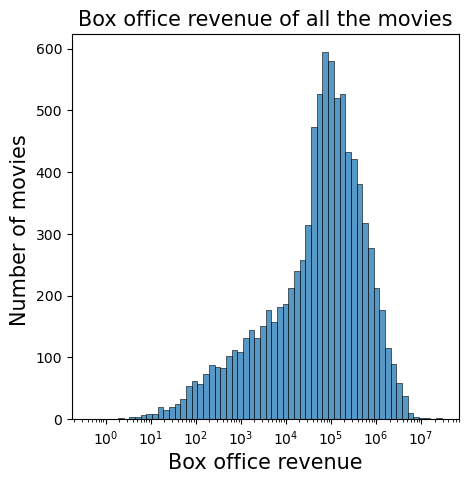

In [34]:
plt.figure(figsize=(5, 5))
plt.xlabel('Box office revenue', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('Box office revenue of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rev], log_scale=True)
plt.show()

Revenue seems to be slightly heavy tailed. Indeed:

In [35]:
metadata_df[box_office_rev].describe()

count    9.017000e+03
mean     2.881933e+05
std      7.859981e+05
min      4.412448e-01
25%      1.188405e+04
50%      7.411329e+04
75%      2.510494e+05
max      2.888889e+07
Name: Movie box office revenue, dtype: float64

The mean is 3.528042e+07, whilst the median is 5.656388e+06, an order of magnitude smaller.
Let's examine the ratings' distribution:

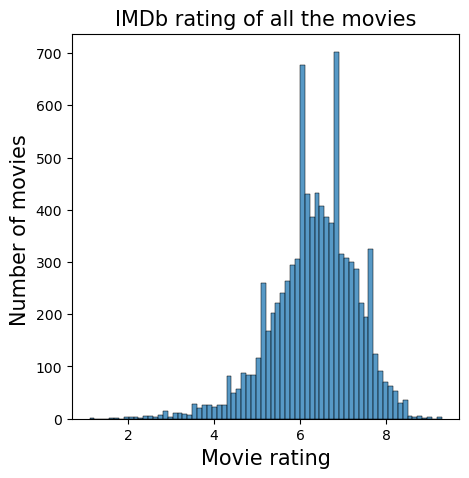

In [36]:
plt.figure(figsize=(5, 5))
plt.xlabel('Movie rating', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('IMDb rating of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rat])
plt.show()

This distribution seems closer to normal, with a few peaks.

In [37]:
metadata_df[box_office_rat].describe()

count    9017.000000
mean        6.336132
std         0.979034
min         1.100000
25%         5.800000
50%         6.400000
75%         7.000000
max         9.300000
Name: averageRating, dtype: float64

Median and mean are close. Is the distribution really approximately normal?

In [38]:
stats.normaltest(metadata_df[box_office_rat])

NormaltestResult(statistic=784.1258366534842, pvalue=5.360903773027567e-171)

p-value is basically 0, we can confidently reject the hypothesis that the data comes from a normal distribution.

Let's have a quick look at the influence of the year when a movie was released on both rating and revenue.

In [39]:
sums_year = metadata_df.groupby('startYear')[[box_office_rev]].sum()[1:]
means_year = metadata_df.sort_values(by="startYear")

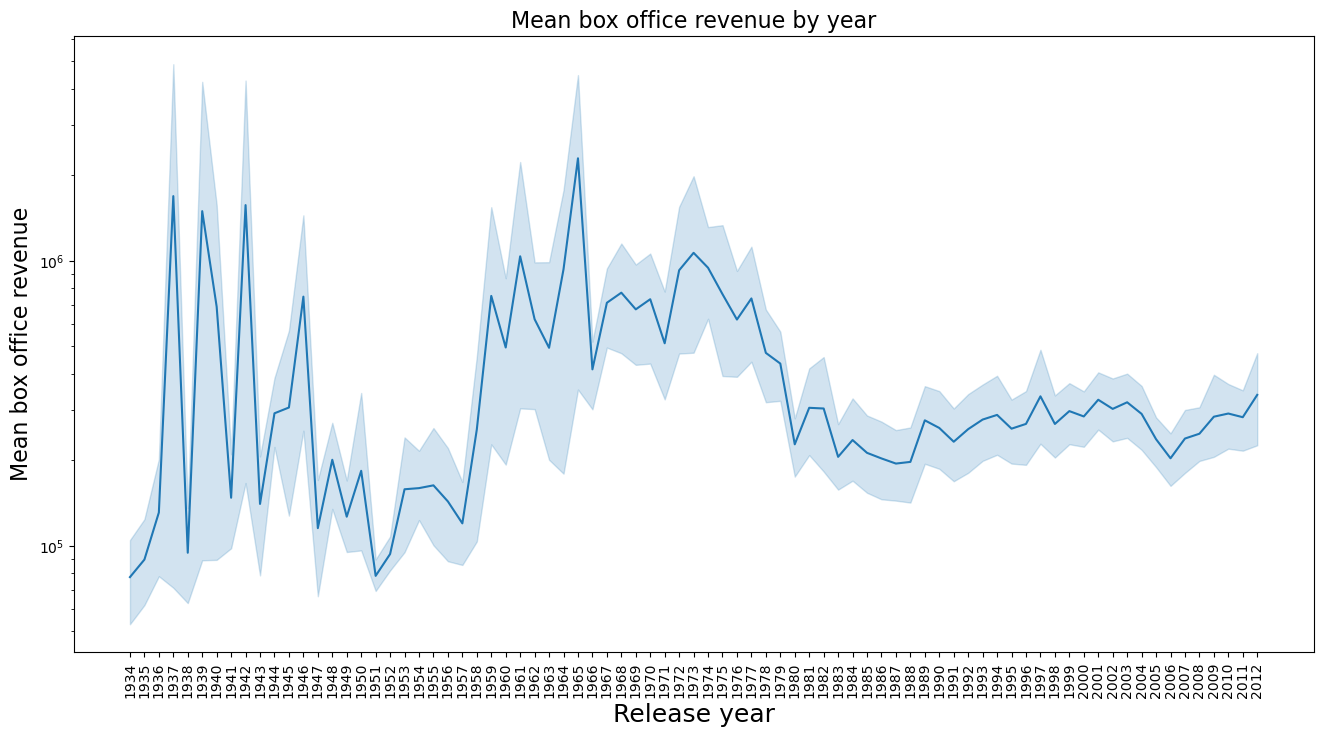

In [41]:
plot_by_year(means_year[80:-10], "Mean", "box office revenue", "Movie box office revenue")

An upwards trend of mean expected revenue is to be expected, especially since more money gets thrown into the film industry:

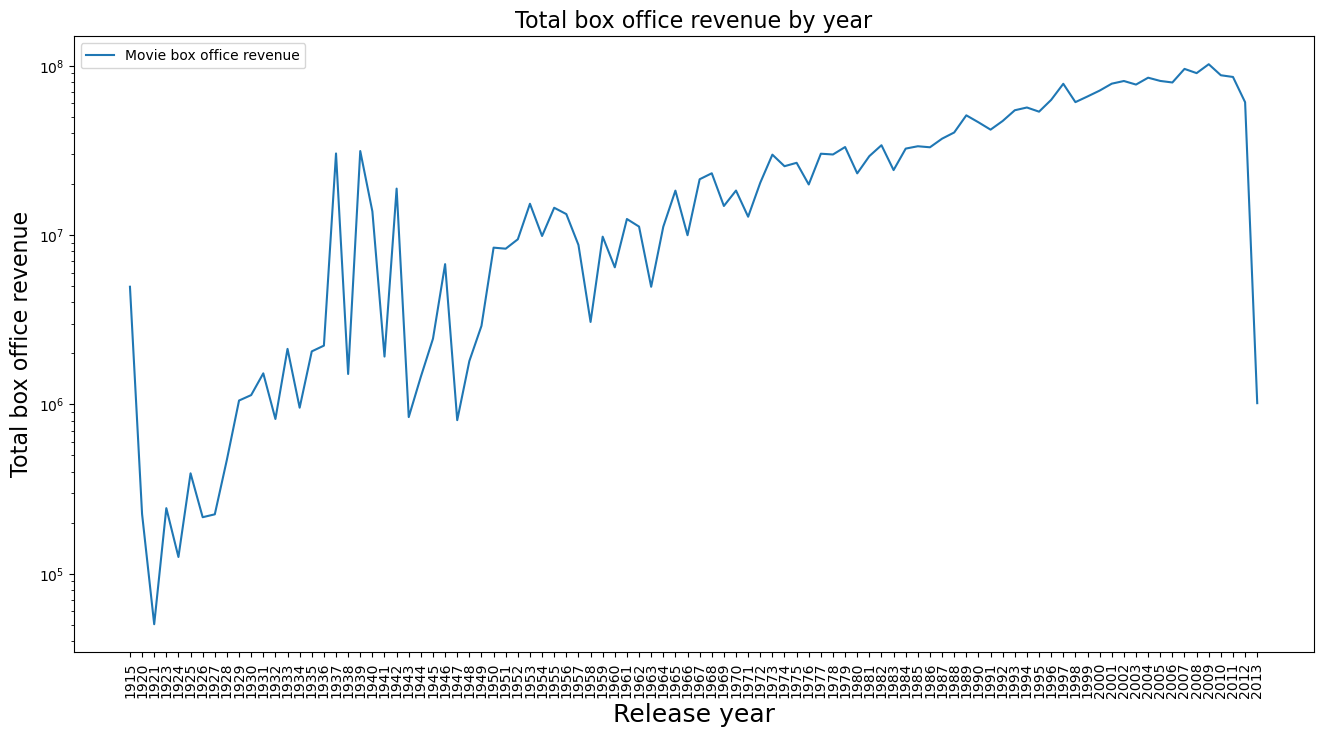

In [42]:
plot_by_year(sums_year, "Total", "box office revenue", "Movie box office revenue")

Now let us do the same for rating:

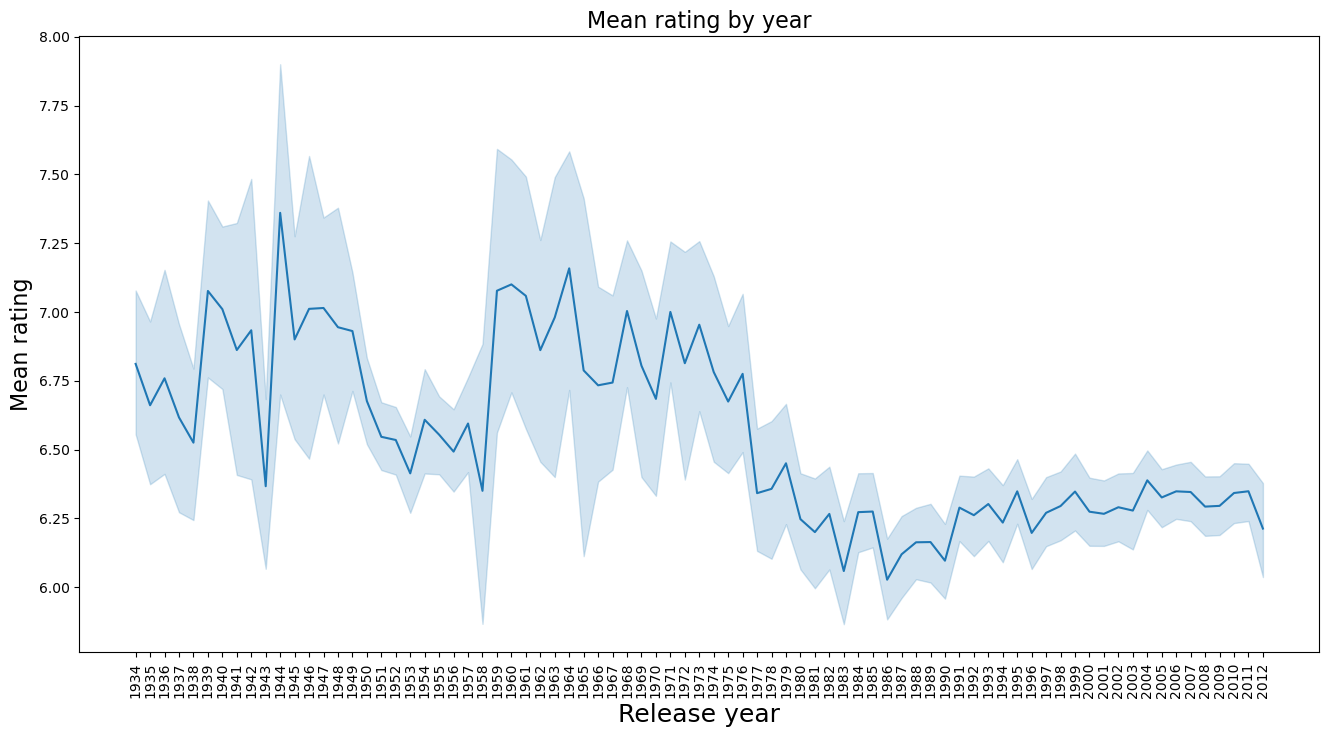

In [43]:
plot_by_year(means_year[80:-10], "Mean", "rating", "averageRating", log_yscale=False)

Interestingly, between the 1960 and the 1985, IMDb average ratings have dropped, before plateauing. We will have to see if this is tied to the number of ratings submitted. Now, what about the dependence between rating and revenue?

In [44]:
stats.spearmanr(metadata_df[box_office_rev], metadata_df[box_office_rat])

SpearmanrResult(correlation=0.17000817187109082, pvalue=1.9012712754586066e-59)

The p-value being this small rejects that rating and revenue are uncorrelated. However, that correlation seems to be small. Later, it might be interesting to have a look at this correlation *per year* rather than globally.

Lastly, we also plot the runtime just to check whether there is anything interesting to be seen:

<AxesSubplot:xlabel='Movie runtime', ylabel='Count'>

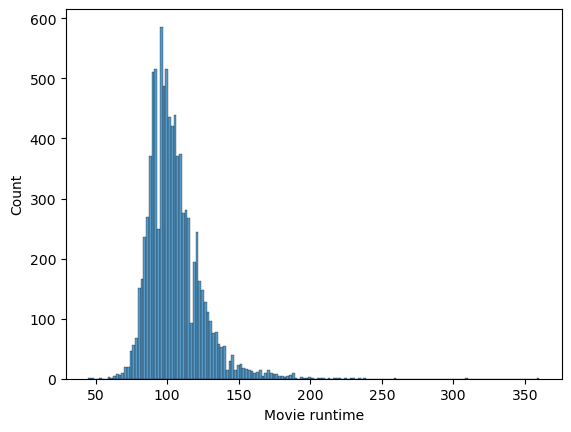

In [45]:
sns.histplot(data=metadata_df["Movie runtime"])

In [46]:
metadata_df["Movie runtime"].describe()

count    9017.000000
mean      104.972108
std        18.840083
min        45.000000
25%        93.000000
50%       101.000000
75%       113.000000
max       360.000000
Name: Movie runtime, dtype: float64

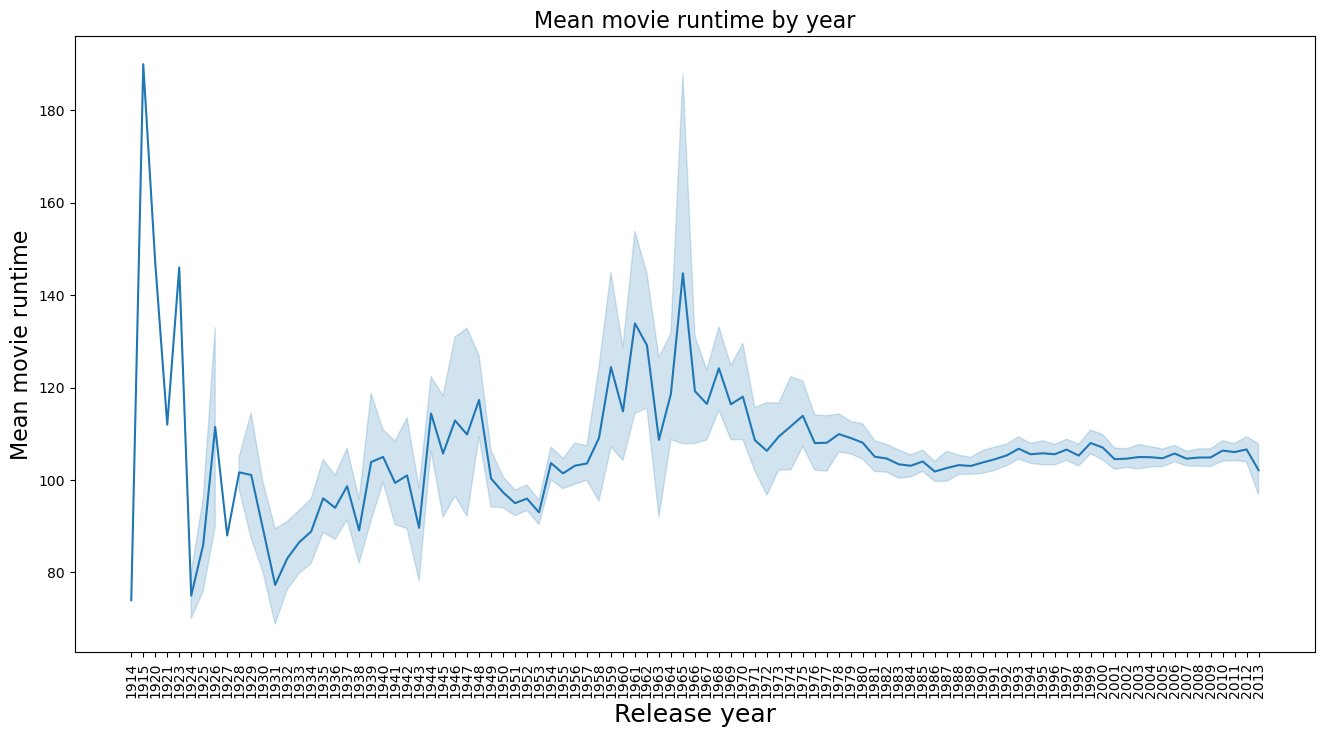

In [47]:
plot_by_year(means_year, "Mean", "movie runtime", "Movie runtime", log_yscale=False)

Runtime has increased during the first half of the 20th century. It might be worth studying how runtime affects rating and revenue.

#### 3.4) Effect of genre, country and language on rating and revenue

We move on to the meat and potatoes of metadata analysis: how genre, country and language affect rating and revenue. Some preprocessing first to add indicator variables for each genre, country and language.

In [49]:
metadata_df.rename(columns={"Movie countries (Freebase ID:name tuples)": "Movie countries",
                    "Movie genres (Freebase ID:name tuples)": "Movie genres"}, inplace=True)

cols_to_process = ["Movie countries", "Movie genres", "Movie languages"]
for col in cols_to_process:
    append_processed_columns(metadata_df, col)

metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries,Movie genres,isAdult,startYear,Movie genres: values,Movie countries: Freebase IDs,Movie countries: values,Movie genres: Freebase IDs,Movie languages: Freebase IDs,Movie languages: values
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,7.911255e+04,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],[United States of America],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],[English Language]
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,9.875401e+05,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",0,2010,"[Science Fiction, Adventure, Fantasy, Comedy, ...",[/m/09c7w0],[United States of America],"[/m/06n90, /m/03k9fj, /m/01hmnh, /m/01z4y, /m/...",[/m/02h40lc],[English Language]
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,2.553191e+05,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",0,1938,"[Musical, Comedy, Black-and-white]",[/m/09c7w0],[United States of America],"[/m/04t36, /m/01z4y, /m/01g6gs]",[/m/02h40lc],[English Language]
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,8.194435e+04,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",0,1989,"[Costume drama, War film, Epic, Period piece, ...",[/m/07ssc],[United Kingdom],"[/m/04xvh5, /m/082gq, /m/06l3bl, /m/04xvlr, /m...",[/m/02h40lc],[English Language]
26,77856,/m/0kcn7,tt0058331,Mary Poppins,Mary Poppins,3.299120e+06,7.8,173140,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",0,1964,"[Children's/Family, Musical, Fantasy, Comedy, ...",[/m/09c7w0],[United States of America],"[/m/0hj3myq, /m/04t36, /m/01hmnh, /m/01z4y, /m...",[/m/02h40lc],[English Language]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,2.440848e+06,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",0,1988,"[Romantic comedy, Comedy of manners, Drama, Co...",[/m/09c7w0],[United States of America],"[/m/06cvj, /m/03p5xs, /m/07s9rl0, /m/01z4y, /m...",[/m/02h40lc],[English Language]
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,1.175943e+05,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...",0,1990,"[Alien Film, Science Fiction, Family Film, Com...",[/m/09c7w0],[United States of America],"[/m/0hj3mt0, /m/06n90, /m/0hqxf, /m/01z4y, /m/...",[/m/02h40lc],[English Language]
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,4.032794e+04,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",0,2000,"[Parody, Americana, Comedy]","[/m/0f8l9c, /m/09c7w0]","[France, United States of America]","[/m/0gf28, /m/09n5t_, /m/01z4y]","[/m/02bjrlw, /m/02h40lc]","[Italian Language, English Language]"
86937,664006,/m/030xw6,tt0107057,Guilty as Sin,Guilty as Sin,1.583822e+05,5.6,5505,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0g

Store all genres and countries encountered:

In [51]:
all_countries = distinct_values(metadata_df, "Movie countries")
all_genres = distinct_values(metadata_df, "Movie genres")
all_languages = distinct_values(metadata_df, "Movie languages")

genre_prefix = "genre"
langs_prefix = "lang"
cntry_prefix = "country"

Then, let's check the resulting dataframe:

In [52]:
for ls in [(all_countries, "Movie countries", cntry_prefix),
            (all_genres, "Movie genres", genre_prefix),
            (all_languages, "Movie languages", langs_prefix)]:
    metadata_df = append_indicator_columns(metadata_df, *ls)

metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,...,lang: Vietnamese Language,lang: Telugu language,lang: French Language,lang: Catalan language,lang: Aboriginal Malay languages,lang: Chechen Language,lang: Dutch Language,lang: Egyptia,lang: Assyrian Neo-Aramaic Language,lang: Inuktitut
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,7.911255e+04,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,9.875401e+05,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,2.553191e+05,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,8.194435e+04,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
26,77856,/m/0kcn7,tt0058331,Mary Poppins,Mary Poppins,3.299120e+06,7.8,173140,139.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,2.440848e+06,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,1.175943e+05,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,4.032794e+04,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...",...,0,0,0,0,0,0,0,0,0,0
86937,664006,/m/030xw6,tt0107057,Guilty as Sin,Guilty as Sin,1.583822e+05,5.6,5505,107.0,{},...,0,0,0,0,0,0,0,0,0,0


For pragmatic purposes such as visualization, we will only treat, in the following, either the $n$ most frequent genres, or genres that are sufficiently frequent.

In [54]:
most_freq_genres = retrieve_n_most_frequent(metadata_df, 35, all_genres, genre_prefix)
suff_freq_genres = retrieve_frequent(metadata_df, all_genres, genre_prefix, freq_threshold=0.03)

most_freq_langs = retrieve_n_most_frequent(metadata_df, 35, all_languages, langs_prefix)
suff_freq_langs = retrieve_frequent(metadata_df, all_languages, langs_prefix, freq_threshold=0.03)

most_freq_cntry = retrieve_n_most_frequent(metadata_df, 35, all_countries, cntry_prefix)
suff_freq_cntry = retrieve_frequent(metadata_df, all_countries, cntry_prefix, freq_threshold=0.03)

Our next step will be to examine genres, countries and languages that have are correlated to rating and revenue, and try to understand which ones optimize either metric.

In [56]:
correlated_genres_to_revenue = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rev, genre_prefix)
correlated_langs_to_revenue = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rev, langs_prefix)
correlated_cntry_to_revenue = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rev, cntry_prefix)

correlated_genres_to_rating = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rat, genre_prefix)
correlated_langs_to_rating = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rat, langs_prefix)
correlated_cntry_to_rating = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rat, cntry_prefix)

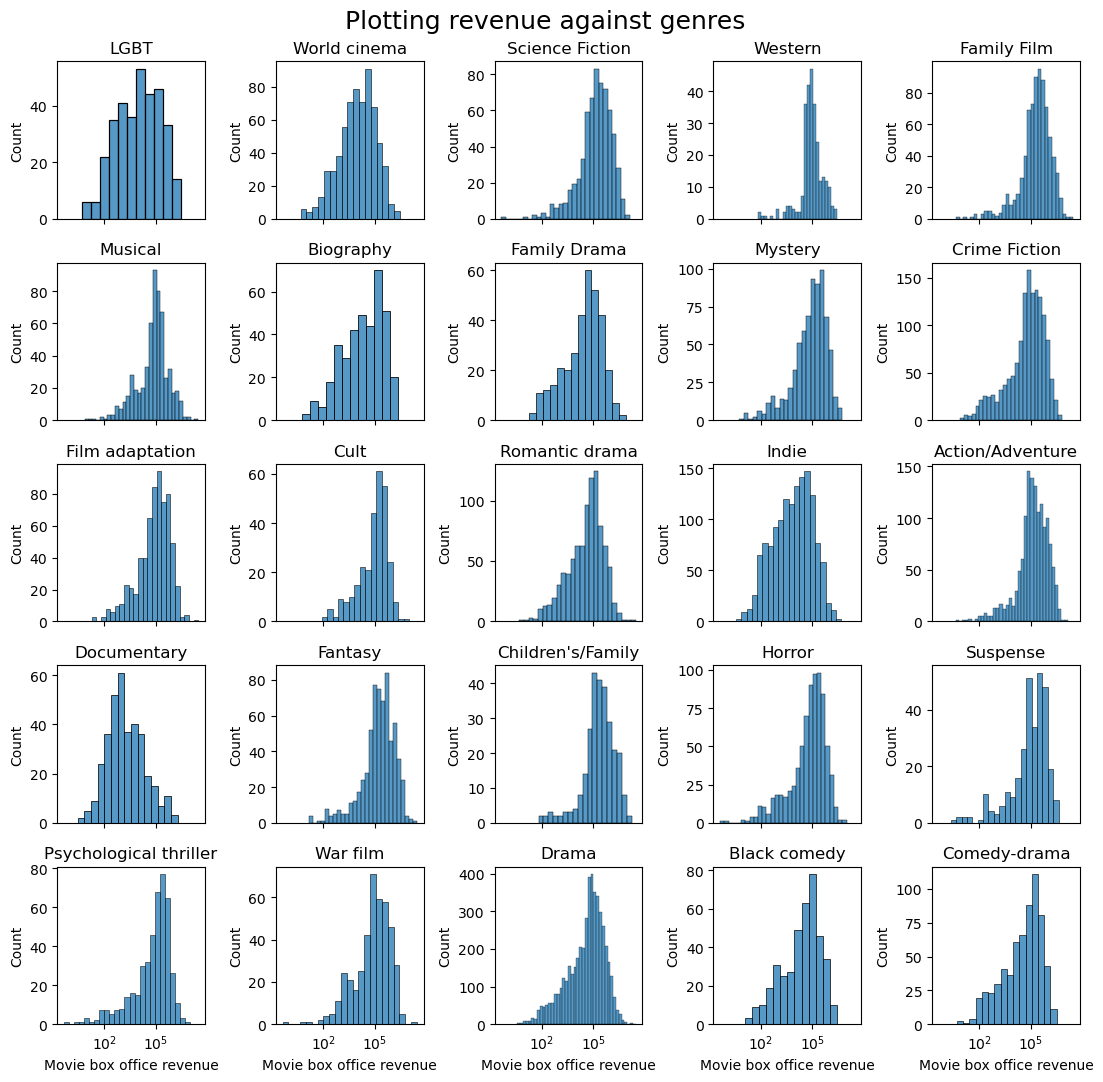

In [58]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_revenue, box_office_rev, title="Plotting revenue against genres")

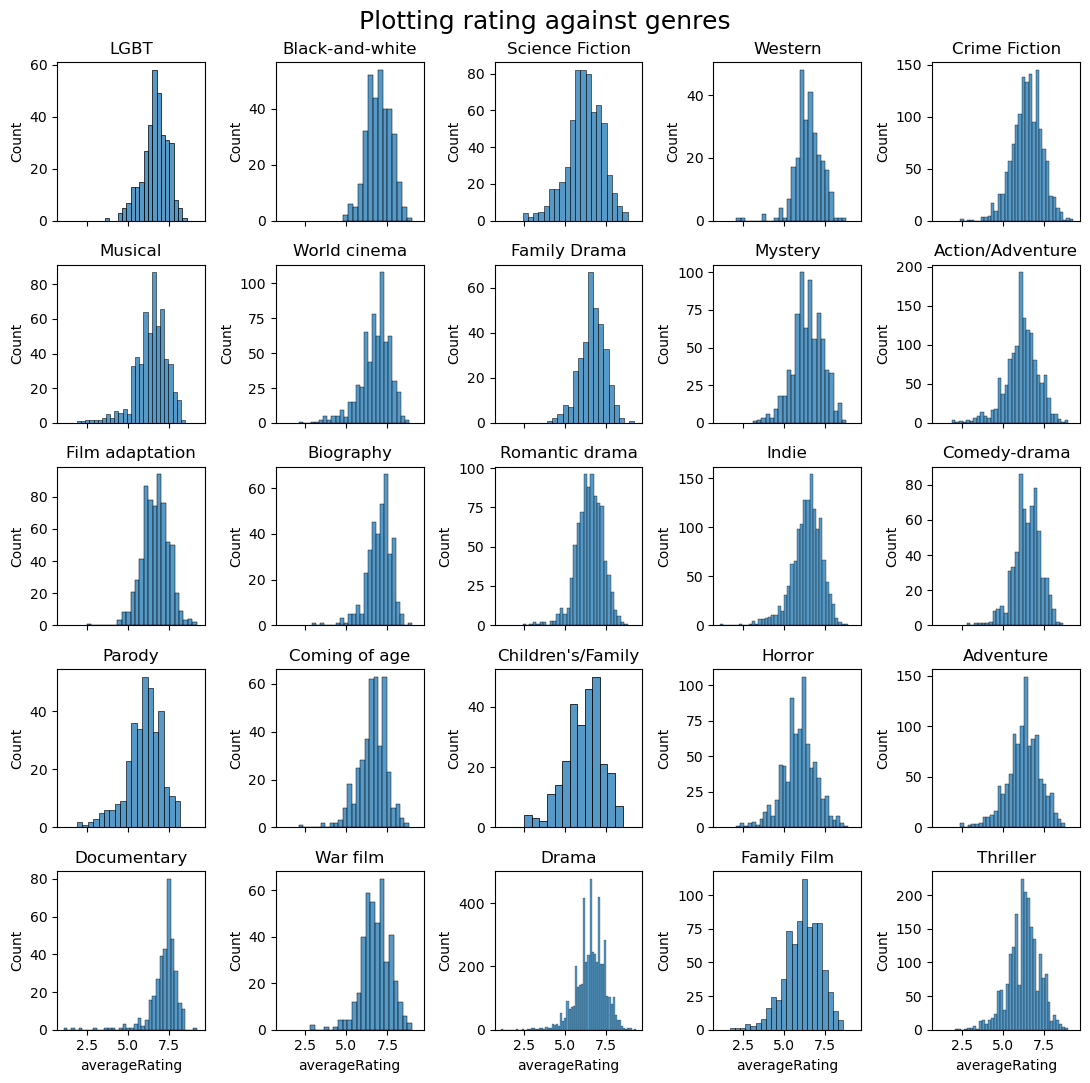

In [59]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_rating, box_office_rat, title="Plotting rating against genres", log_scale=False)

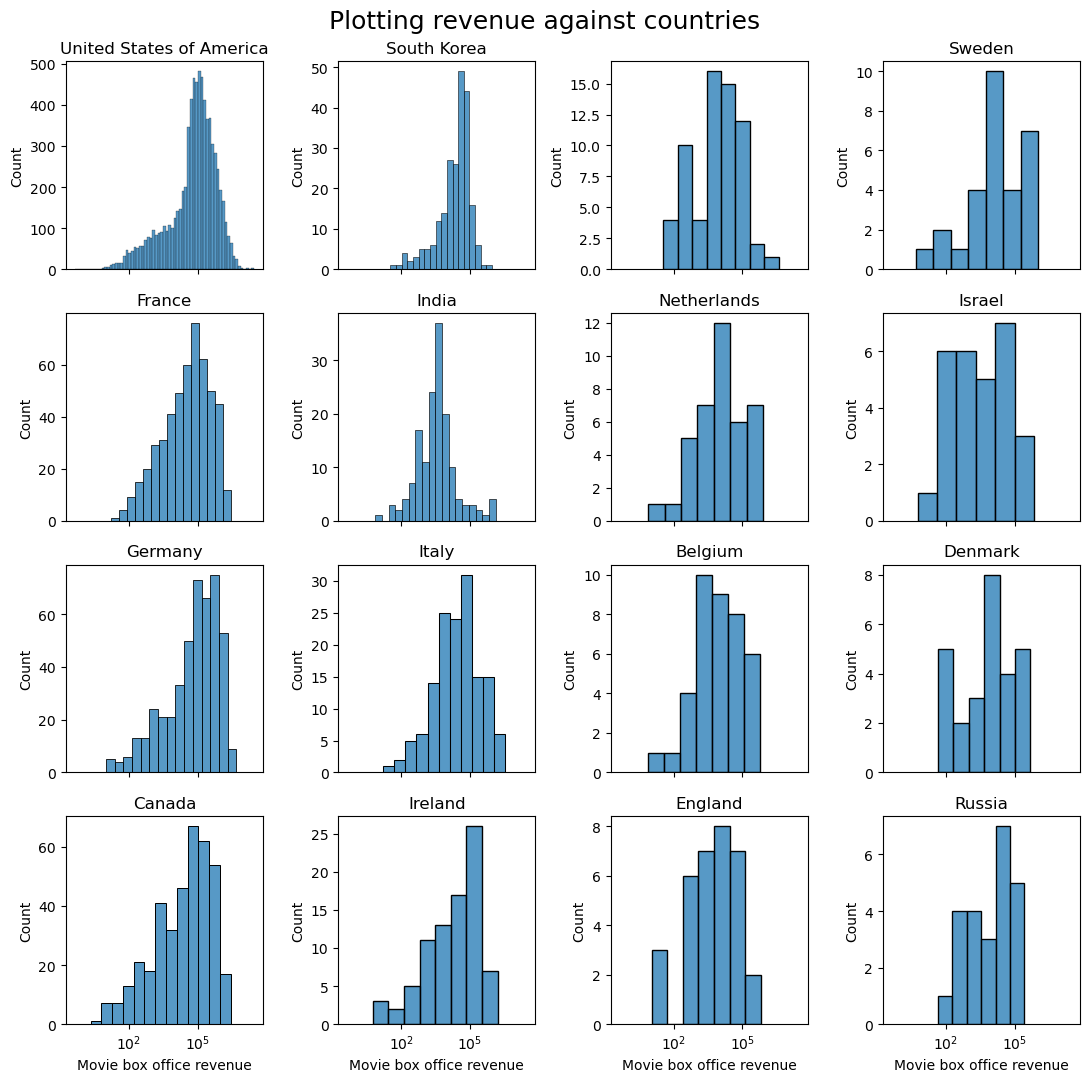

In [60]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_revenue, box_office_rev, title="Plotting revenue against countries")

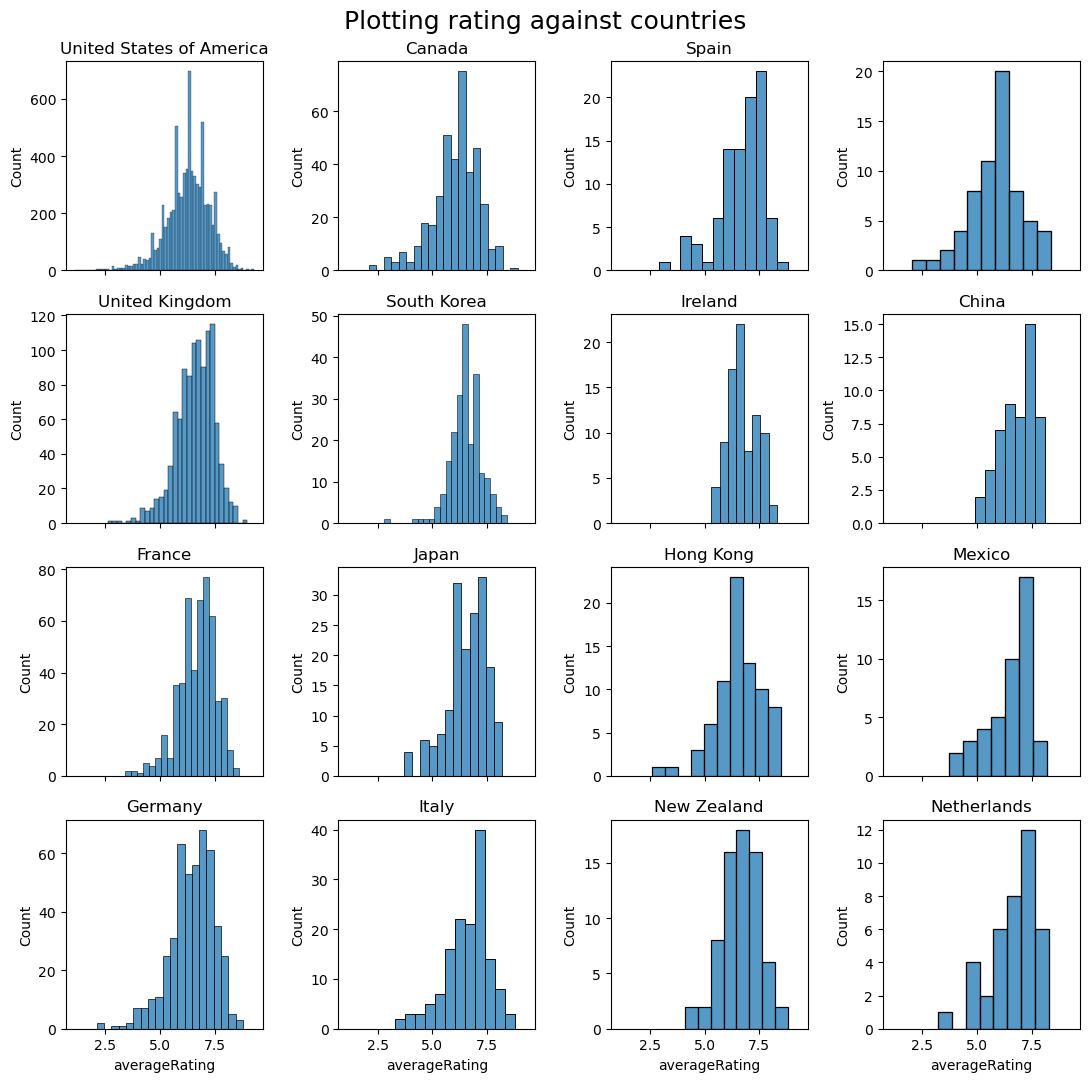

In [61]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_rating, box_office_rat, title="Plotting rating against countries", log_scale=False)

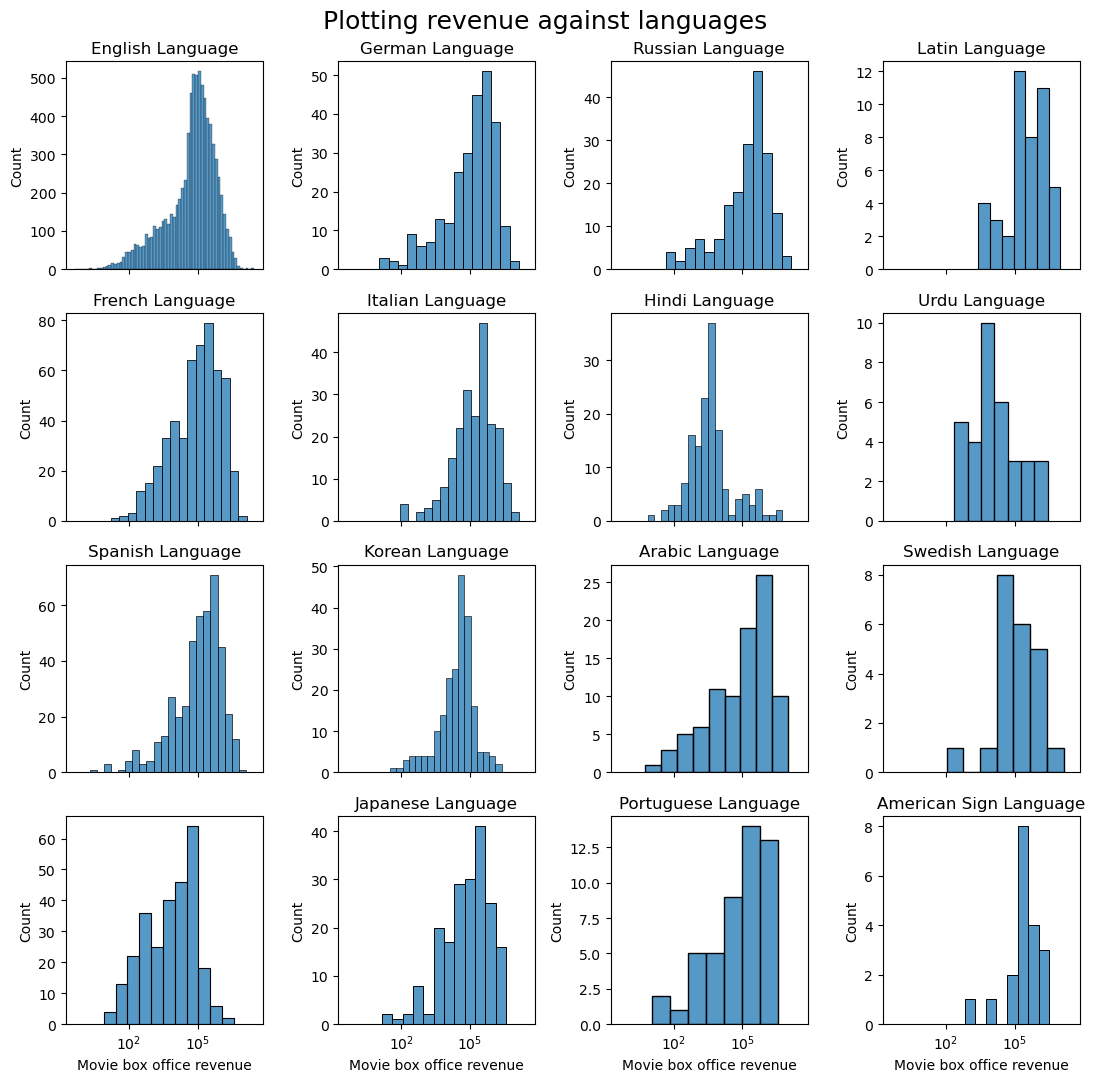

In [62]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_revenue, box_office_rev, title="Plotting revenue against languages")

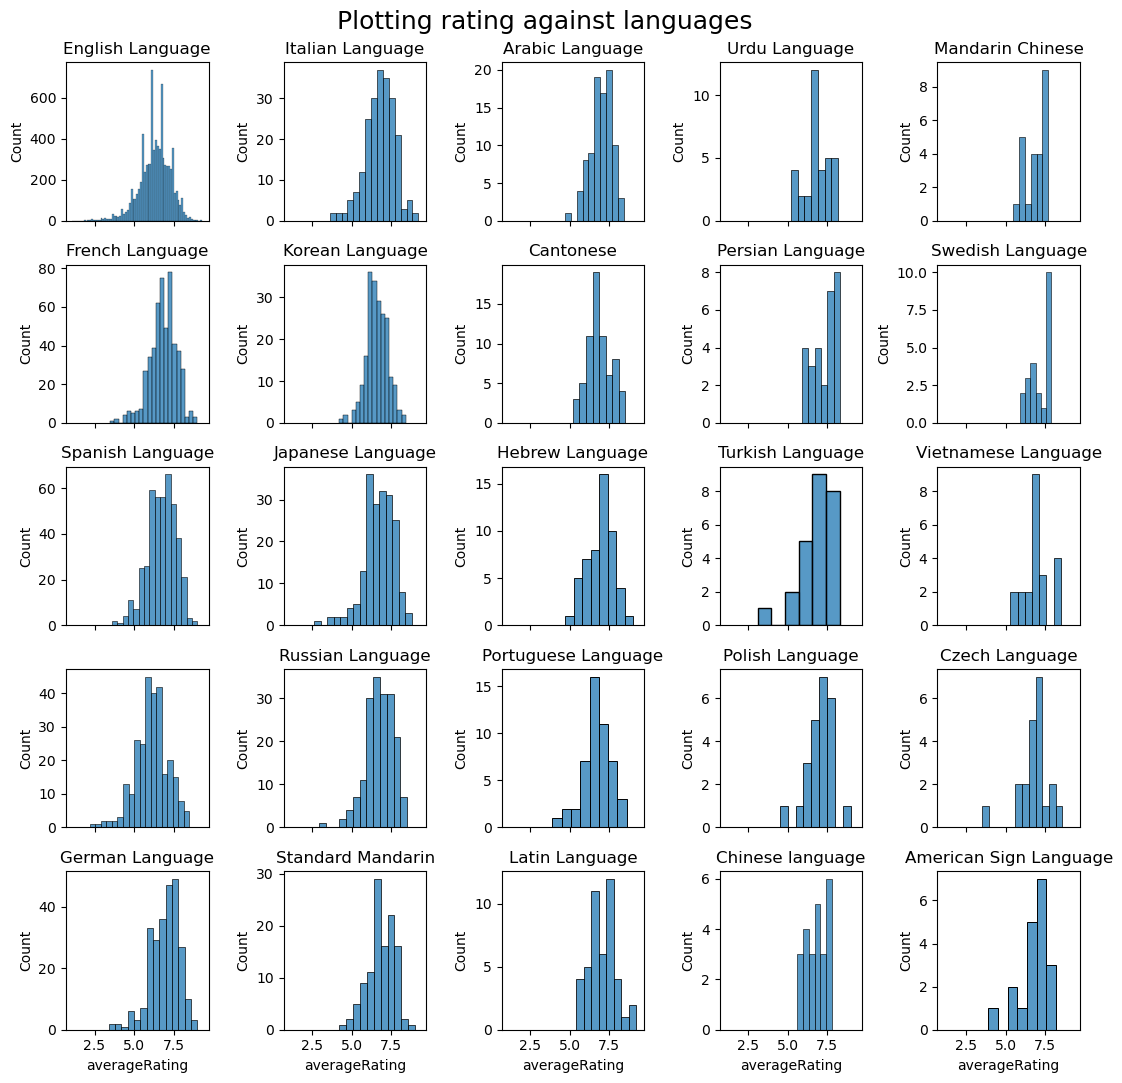

In [63]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_rating, box_office_rat, title="Plotting rating against languages", log_scale=False)

Interesting differences can already be seen. For example, the 3 initial peaks in the rating histogram have become 5 peaks in English drama movies coming from the US. Later, it will be interesting to check the correlation of rating and revenue on a *per year* basis too.

In [65]:
reg_rating_genres = linear_reg(box_office_rat, genre_prefix, correlated_genres_to_rating)
print(reg_rating_genres.summary())


                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     63.84
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:21:48   Log-Likelihood:                -11706.
No. Observations:                9017   AIC:                         2.348e+04
Df Residuals:                    8985   BIC:                         2.370e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [66]:
q_box_office_rev = f"pat.Q('{box_office_rev}')"
reg_revenue_genres = linear_reg(q_box_office_rev, genre_prefix, correlated_genres_to_revenue)
print(reg_revenue_genres.summary())

                                    OLS Regression Results                                   
Dep. Variable:     pat.Q('Movie box office revenue')   R-squared:                       0.093
Model:                                           OLS   Adj. R-squared:                  0.090
Method:                                Least Squares   F-statistic:                     28.89
Date:                               Wed, 21 Dec 2022   Prob (F-statistic):          1.48e-164
Time:                                       18:21:49   Log-Likelihood:            -1.3476e+05
No. Observations:                               9017   AIC:                         2.696e+05
Df Residuals:                                   8984   BIC:                         2.698e+05
Df Model:                                         32                                         
Covariance Type:                           nonrobust                                         
                                                     coef   

### 3) Actors Metadata analysis

Here we focus on analysing the characters metadata in ``charcater.metadata.tsv``

In [67]:
# Load the dataset
names_char = ['Wikipedia movie ID',
              'Freebase movie ID',
              'Movie release date',
              'Character name',
              'Actor date of birth',
              'Actor gender',
              'Actor height',
              'Actor ethnicity',
              'Actor name',
              'Actor age at movie release',
              'Freebase character/actor map ID',
              'Freebase character ID',
              'Freebase actor ID']

characters_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', names = names_char)

In [68]:
characters_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [69]:
characters_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int64  
 1   Freebase movie ID                450669 non-null  object 
 2   Movie release date               440674 non-null  object 
 3   Character name                   192794 non-null  object 
 4   Actor date of birth              344524 non-null  object 
 5   Actor gender                     405060 non-null  object 
 6   Actor height                     154824 non-null  float64
 7   Actor ethnicity                  106058 non-null  object 
 8   Actor name                       449441 non-null  object 
 9   Actor age at movie release       292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  Freebase character ID            192804 non-null  object 
 12  Fr

In [70]:
characters_metadata_df['Actor gender'].describe()

count     405060
unique         2
top            M
freq      270257
Name: Actor gender, dtype: object

##### Age at movie release:

In [71]:
characters_metadata_df['Actor age at movie release'].describe()

count    292556.000000
mean         37.788523
std          20.587870
min       -7896.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Actor age at movie release, dtype: float64

We noticed that the attribute 'Age at movie release' contains negative values

In [72]:
characters_metadata_df[characters_metadata_df['Actor age at movie release'] < 0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999-10-03,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


In [73]:
characters_metadata_df['Actor age at movie release'] = characters_metadata_df['Actor age at movie release'].apply(abs)

(0.0, 100.0)

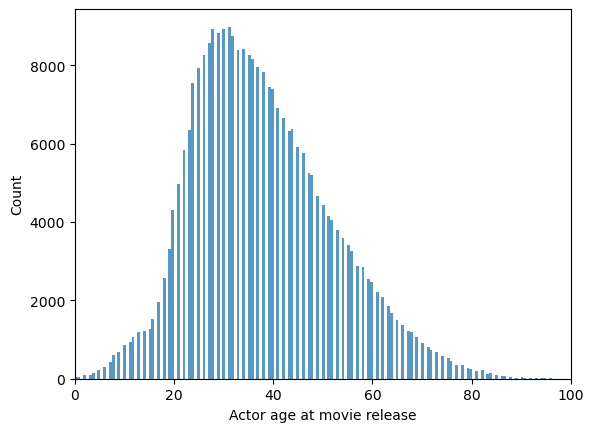

In [74]:
sns.histplot(data=characters_metadata_df, x="Actor age at movie release")
plt.xlim(0, 100)

We remove wrong character entries, given that the longest-lived person in the world died at age 122.

In [75]:
characters_metadata_df = characters_metadata_df[characters_metadata_df['Actor age at movie release'] < 122]

#### Effect of gender on movie revenue

In [76]:
characters_metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450660,913762,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz
450661,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j


In [77]:
characters_metadata_df2 = characters_metadata_df.join(pd.get_dummies(characters_metadata_df['Actor gender']).rename(columns=lambda x : f'{x}_onehot'))

In [78]:
characters_metadata_df2

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,F_onehot,M_onehot
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1,0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,0,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,0,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450660,913762,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,0,1
450661,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,0,1
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1,0
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,0,1


In [79]:
revenue_df = metadata_df[['Wikipedia movie ID', 'Movie box office revenue']]
rating_df = metadata_df[['Wikipedia movie ID', 'averageRating']]

In [ ]:
characters_metadata_revenue = characters_metadata_df2.merge(revenue_df, left_on='Wikipedia movie ID', right_on = 'Wikipedia movie ID', how='inner')

In [80]:
characters_metadata_rating = characters_metadata_df2.merge(rating_df, left_on='Wikipedia movie ID', right_on = 'Wikipedia movie ID', how='inner')

In [81]:
characters_metadata_revenue

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,F_onehot,M_onehot,Movie box office revenue
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1,0,79112.546584
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1,0,79112.546584
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,0,1,79112.546584
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,0,1,79112.546584
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1,0,79112.546584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83733,6456053,/m/0g605h,1964-12-31,Lady Angela St. Simeon,1923-08-06,F,NaN,NaN,Moira Lister,41.0,/m/0cg4r4r,/m/0hnw0m8,/m/07pfcc,1,0,174193.548387
83734,6456053,/m/0g605h,1964-12-31,Assistant Car Salesman,1933-07-26,M,NaN,NaN,Lance Percival,31.0,/m/0cg01yt,/m/0hnw0ly,/m/052k8b,0,1,174193.548387
83735,6456053,/m/0g605h,1964-12-31,Norwood,1900-08-31,M,NaN,NaN,Roland Culver,64.0,/m/0cs4ftp,/m/0hnw0kl,/m/0412scr,0,1,174193.548387
83736,6456053,/m/0g605h,1964-12-31,Harnsworth,1911-10-03,M,NaN,NaN,Michael Hordern,53.0,/m/0csk5b4,/m/0hnw0mv,/m/015vql,0,1,174193.548387


In [82]:
mod = smf.ols(formula='Q("Movie box office revenue") ~ C(F_onehot) + C(M_onehot)', data=characters_metadata_revenue)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print the summary output provided by the library.
print(res.summary())

In [ ]:
mod = smf.ols(formula='averageRating ~ C(F_onehot) + C(M_onehot)', data=characters_metadata_rating)
np.random.seed(2)
res = mod.fit()
print(res.summary())

#### Effect of actor age on revenue

In [ ]:
age_revenue_groups = characters_metadata_revenue.groupby(['Actor age at movie release']).mean()
age_rating_groups = characters_metadata_rating.groupby(['Actor age at movie release']).mean()

In [ ]:
age_revenue_groups

In [ ]:
age_rating_groups

In [84]:
merged = age_rating_groups.merge(age_revenue_groups, on = 'Actor age at movie release')[['averageRating', 'Movie box office revenue']]

                                  OLS Regression Results                                 
Dep. Variable:     Q("Movie box office revenue")   R-squared:                       0.000
Model:                                       OLS   Adj. R-squared:                  0.000
Method:                            Least Squares   F-statistic:                     7.288
Date:                           Wed, 21 Dec 2022   Prob (F-statistic):            0.00694
Time:                                   18:09:27   Log-Likelihood:            -1.2733e+06
No. Observations:                          83738   AIC:                         2.547e+06
Df Residuals:                              83736   BIC:                         2.547e+06
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]


In [85]:
merged = merged.reset_index()

In [ ]:
# For the plot
#merged.to_csv('age_rating_revenue.csv', index=False)

##### Titles known for:
Since our study focuses on analysing features that contribute to a movie's success, it would be relevant to study actors performance. This can be done by having information on when each actor performed the best.
For this task, we used the  ``imdb_name_basics.tsv`` dataset, which contains the 4 topmost titles an actor is known for.

**IMDb actors dataset:**

- **nconst**: unique identifier of person
- **primaryName**: name the person is known for
- **birthYear**: birth year
- **deathYear**: death year
- **primaryProfession**: top 3 professions of the person
- **knownForTitles**: movies the person is known for


In [87]:
# Load the IMDb actors dataset
imdb_actors_df = pd.read_csv('data/imdb_name_basics.tsv', sep='	')

In [88]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0117057,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0077975,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0060827,tt0050986"


In [89]:
imdb_actors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060121 entries, 0 to 12060120
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   nconst             object
 1   primaryName        object
 2   birthYear          object
 3   deathYear          object
 4   primaryProfession  object
 5   knownForTitles     object
dtypes: object(6)
memory usage: 552.1+ MB


Since we only have the id of the known for titles, we fetch the title names from the `imdb_names_df`

First we separate each of the titles ids an actor is known for in a single column, then we fetch the name corresponding to each id.

In [ ]:
imdb_actors_df['knownForTitles1'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(0))
imdb_actors_df['knownForTitles2'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(1))
imdb_actors_df['knownForTitles3'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(2))
imdb_actors_df['knownForTitles4'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(3))

In [ ]:
imdb_actors_df.head()

In [ ]:
# IMDb movies' metadata dataset
imdb_names_df.head()

In [ ]:
# Keep only relevant columns
imdb_names_reduced_df = imdb_names_df[["tconst", "primaryTitle"]]

In [463]:
imdb_actors_df = assign_known_title(1, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(2, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(3, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(4, imdb_actors_df, imdb_names_reduced_df)

In [464]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137",The Story of Vernon and Irene Castle,The Towering Inferno,Funny Face,On the Beach
1,nm0461772,Frederic Knudtson,1906,1964,"editor,editorial_department","tt0053946,tt0055031,tt0057193,tt0053137",Inherit the Wind,Judgment at Nuremberg,It's a Mad Mad Mad Mad World,On the Beach
2,nm0254666,Walter Elliott,1903,1984,"sound_department,music_department","tt0057193,tt0053946,tt0055031,tt0053137",It's a Mad Mad Mad Mad World,Inherit the Wind,Judgment at Nuremberg,On the Beach
3,nm1298827,Marie Cowan,\N,\N,"soundtrack,composer","tt0455824,tt0220134,tt0105824,tt0053137",Australia,Up Jumped a Swagman,Wind,On the Beach
4,nm0542596,Nellie Manley,1894,1976,make_up_department,"tt0052357,tt0054698,tt0050419,tt0051201",Vertigo,Breakfast at Tiffany's,Funny Face,Witness for the Prosecution


In [465]:
imdb_actors_df['knownForTitlesNames'] = imdb_actors_df[imdb_actors_df.columns[6:]].apply(
    lambda x: ','.join(x),
    axis=1
)

In [466]:
imdb_actors_df = imdb_actors_df.drop('knownForTitles1', axis = 1).drop('knownForTitles2', axis = 1).drop('knownForTitles3', axis = 1).drop('knownForTitles4', axis = 1)

In [467]:
imdb_actors_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,knownForTitlesNames
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0050419,tt0053137","The Story of Vernon and Irene Castle,The Tower..."
1,nm0461772,Frederic Knudtson,1906,1964,"editor,editorial_department","tt0053946,tt0055031,tt0057193,tt0053137","Inherit the Wind,Judgment at Nuremberg,It's a ..."
2,nm0254666,Walter Elliott,1903,1984,"sound_department,music_department","tt0057193,tt0053946,tt0055031,tt0053137","It's a Mad Mad Mad Mad World,Inherit the Wind,..."
3,nm1298827,Marie Cowan,\N,\N,"soundtrack,composer","tt0455824,tt0220134,tt0105824,tt0053137","Australia,Up Jumped a Swagman,Wind,On the Beach"
4,nm0542596,Nellie Manley,1894,1976,make_up_department,"tt0052357,tt0054698,tt0050419,tt0051201","Vertigo,Breakfast at Tiffany's,Funny Face,Witn..."


As an example, let's see what are the titles Leonardo Dicaprio is known for

In [468]:
result = imdb_actors_df[imdb_actors_df['primaryName'] == "Leonardo DiCaprio"]['knownForTitlesNames']
print(result)

13266    The Wolf of Wall Street,Titanic,The Departed,I...
Name: knownForTitlesNames, dtype: object


No surprise !

We add the IMDb's casting dataset. It contains the people that have participated in castings for movies and their role in them.
We are not directly using this dataframe in Milestone 2 as it will be joined and applied to data obtained by methods in Milestone 3 (refer to Method 2 at Readme for further information).

**IMDb castings dataset:**

- **tconst**: unique identifier of title
- **ordering**: index identify a row within a specific title
- **nconst**: unique identifier of person
- **category**: category of job in casting
- **job**: job title
- **characters**: name of character if it was an interpretation role

In [481]:
# IMDb castings dataset
imdb_casting_df = pd.read_csv('data/imdb_title_principals.tsv', sep='	', low_memory=False)
imdb_casting_df.head()

In [482]:
m = imdb_casting_df[imdb_casting_df['category'] == 'actor']

In [483]:
m['characters']

### Graph of actors' interactions

In [149]:
# Dataframe that contains the relevant character information
characters_df = characters_metadata_df[['Wikipedia movie ID', 'Freebase actor ID', 'Actor name', 'Character name']]
print("Number of characters:", characters_df.shape[0])
characters_df.head()

Number of characters: 292553


,Wikipedia movie ID,Freebase actor ID,Actor name,Character name
0,975900,/m/03wcfv7,Wanda De Jesus,Akooshay
1,975900,/m/0346l4,Natasha Henstridge,Lieutenant Melanie Ballard
2,975900,/m/01vw26l,Ice Cube,Desolation Williams
3,975900,/m/034hyc,Jason Statham,Sgt Jericho Butler
4,975900,/m/01y9xg,Clea DuVall,Bashira Kincaid


In [150]:
# Number of actors in the character dataframe
nb_actors = characters_df['Freebase actor ID'].nunique()
print("Number of actors:", nb_actors)

Number of actors: 51953


In [151]:
# Movies' metadata dataframe
movies_metadata_df = metadata_df.copy()
movies_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,...,lang: Vietnamese Language,lang: Telugu language,lang: French Language,lang: Catalan language,lang: Aboriginal Malay languages,lang: Chechen Language,lang: Dutch Language,lang: Egyptia,lang: Assyrian Neo-Aramaic Language,lang: Inuktitut
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,7.911255e+04,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,9.875401e+05,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
14,10408933,/m/02qc0j7,tt0029852,Alexander's Ragtime Band,Alexander's Ragtime Band,2.553191e+05,6.9,2159,106.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
19,171005,/m/016ywb,tt0097499,Henry V,Henry V,8.194435e+04,7.5,30161,137.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0
26,77856,/m/0kcn7,tt0058331,Mary Poppins,Mary Poppins,3.299120e+06,7.8,173140,139.0,"{""/m/02h40lc"": ""English Language""}",...,0,0,0,0,0,0,0,0,0,0


In [168]:
most_freq_genres_graph = retrieve_n_most_frequent(metadata_df, 35, all_genres, genre_prefix)
print(most_freq_genres_graph)

['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Crime Fiction', 'Indie', 'Action/Adventure', 'Adventure', 'Romantic comedy', 'Romantic drama', 'Family Film', 'Horror', 'Period piece', 'Mystery', 'Crime Thriller', 'Film adaptation', 'Fantasy', 'World cinema', 'Comedy-drama', 'Science Fiction', 'Musical', 'Psychological thriller', 'War film', 'Teen', 'Coming of age', 'Black comedy', 'Biography', 'Documentary', 'Sports', 'Parody', 'Black-and-white', 'LGBT', 'Family Drama', 'Suspense']


In [169]:
for genre in most_freq_genres_graph[:1]:
    metadata_graph_df = get_metadata_df_from_genre(genre, movies_metadata_df, do_filter=True, filter_on_revenue=True, n_filter=1000)
    characters_graph_df, nb_actors = merge_characters_films(characters_df, metadata_graph_df)
    create_graph(characters_graph_df, genre, nb_actors, weight_on_revenue=True)
    print("Created graph for genre", genre)
    print("--------------------------")

Number of films for genre Drama : 4848
Number of films for genre  Drama (max 1000 after filter) : 1000
After merging, number of characters: 12652
After merging, number of actors: 6899
After merging, number of films: 978
Created array and dictionary of actors. First 5 entries of array_actors:
[('/m/01gw8b', 'Jill Clayburgh') ('/m/05xd_v', 'Michael Murphy')
 ('/m/0h7hcy', 'Cliff Gorman') ('/m/0n8dn1w', 'Patricia Quinn')
 ('/m/03_28z', 'Kelly Bishop')]
Grouped characters by film
Populated adjacency matrix
Created graph csv file, number of edges: 82912
Created graph for genre Drama
--------------------------


In [170]:
# metadata_graph_df = get_metadata_df_from_genre('Action/Adventure', movies_metadata_df, do_filter=True, filter_on_revenue=True, n_filter=1000)
# characters_graph_df, nb_actors = merge_characters_films(characters_df, metadata_graph_df)

Number of films for genre Action/Adventure : 1387
Number of films for genre  Action/Adventure (max 1000 after filter) : 1000
After merging, number of characters: 11544
After merging, number of actors: 6223
After merging, number of films: 980


In [173]:
# characters_graph_df.head()

,Wikipedia movie ID,Freebase actor ID,Actor name,Character name,primaryTitle,originalTitle,Movie genres: values,Movie box office revenue,averageRating
0,261237,/m/0cmbfw3,Brian O'Shaughnessy,NaN,The Gods Must Be Crazy,The Gods Must Be Crazy,"[Adventure, Action/Adventure, Indie, World cin...",416647.851942,7.3
1,261237,/m/0fdctd,Ken Gampu,NaN,The Gods Must Be Crazy,The Gods Must Be Crazy,"[Adventure, Action/Adventure, Indie, World cin...",416647.851942,7.3
2,261237,/m/02xyxp,Jamie Uys,NaN,The Gods Must Be Crazy,The Gods Must Be Crazy,"[Adventure, Action/Adventure, Indie, World cin...",416647.851942,7.3
3,261237,/m/027dv5t,Sandra Prinsloo,NaN,The Gods Must Be Crazy,The Gods Must Be Crazy,"[Adventure, Action/Adventure, Indie, World cin...",416647.851942,7.3
4,261237,/m/06_1tj,Marius Weyers,NaN,The Gods Must Be Crazy,The Gods Must Be Crazy,"[Adventure, Action/Adventure, Indie, World cin...",416647.851942,7.3


In [163]:
# characters_graph_df[characters_graph_df['Actor name'] == "Al Pacino"]

,Wikipedia movie ID,Freebase actor ID,Actor name,Character name,primaryTitle,originalTitle,Movie genres: values,Movie box office revenue,averageRating
3200,11288620,/m/0bj9k,Al Pacino,Rooster,Righteous Kill,Righteous Kill,"[Thriller, Crime Fiction, Psychological thrill...",3.564663e+05,6.0
3680,2466773,/m/0bj9k,Al Pacino,Michael Corleone,The Godfather,The Godfather,"[Crime Fiction, Gangster Film, Crime Drama, Fa...",6.423445e+06,9.2
4779,73875,/m/0bj9k,Al Pacino,Michael Corleone,The Godfather Part II,The Godfather Part II,"[Crime Fiction, Gangster Film, Drama, Crime Dr...",3.914807e+06,9.0
4813,101914,/m/0bj9k,Al Pacino,Sonny,Dog Day Afternoon,Dog Day Afternoon,"[LGBT, Crime Fiction, Crime Drama, Docudrama, ...",9.293680e+05,8.0
5129,222500,/m/0bj9k,Al Pacino,Tony D'Amato,Any Given Sunday,Any Given Sunday,"[Sports, Ensemble Film, Drama]",6.016256e+05,6.9
6374,2541839,/m/0bj9k,Al Pacino,Det. Frank Keller,Sea of Love,Sea of Love,"[Thriller, Crime Fiction, Detective, Mystery, ...",8.941896e+05,6.8
6463,4760936,/m/0bj9k,Al Pacino,Will Dormer,Insomnia,Insomnia,"[Thriller, Crime Fiction, Remake, Psychologica...",6.321002e+05,7.2
8436,43566,/m/0bj9k,Al Pacino,Lt. Vincent Hanna,Heat,Heat,"[Thriller, Crime Fiction, Heist, Psychological...",1.229900e+06,8.3
9043,163459,/m/0bj9k,Al Pacino,Frank Serpico,Serpico,Serpico,"[Crime Fiction, Thriller, Biography, Social pr...",6.711712e+05,7.7
9244,129644,/m/0bj9k,Al Pacino,Michael Corleone,The Godfather Part III,The Godfather Part III,"[Crime Fiction, Thriller, Gangster Film, Crime...",1.046412e+06,7.6


In [174]:
# create_graph(characters_graph_df, 'Action/Adventure', nb_actors, weight_on_revenue=True)

Created array and dictionary of actors. First 5 entries of array_actors:
[('/m/0cmbfw3', "Brian O'Shaughnessy") ('/m/0fdctd', 'Ken Gampu')
 ('/m/02xyxp', 'Jamie Uys') ('/m/027dv5t', 'Sandra Prinsloo')
 ('/m/06_1tj', 'Marius Weyers')]
Grouped characters by film
Populated adjacency matrix
Created graph csv file, number of edges: 69529


In [ ]:
# graph_gephi = pd.read_csv("data/gephi_graph.csv",sep=",")[['Id','modularity_class']]
# graph_gephi.head()

In [ ]:
# clusters_graph = graph_gephi.groupby(['modularity_class'])

# for cluster in clusters_graph.groups.keys():
#    actors = clusters_graph.get_group(cluster)
#    print("CLUSTER", cluster, ", length", actors.shape[0])
#    for i, actor in actors.iterrows():
#        print(actor['Id'])
#    print("------------")

### tvtropes clusters analysis

Here we use the clusters in ``tvtropes.clusters.txt`` to see what type of characters an actor tends to play.

In [ ]:
# Load the data into a dataframe
with open('data/tvtropes.clusters.txt') as f:
    d = []
    for row in f.readlines():
        t, json_data = row.split('\t')
        data = json.loads(json_data)
        data['type'] = t
        d.append(data)

tv_tropes_df = pd.DataFrame(d)
#tv_tropes_df.set_index("id", inplace=True)

In [ ]:
tv_tropes_df.head()

In [ ]:
# split the type in tokens
tv_tropes_df['type'] = tv_tropes_df['type'].apply(lambda x: ' '.join(x.split('_')))

In [ ]:
tv_tropes_df['type'].head()

In order to have better insight on the data and also for further analysis on what type of characters are played by each actor, we decide to conduct sentiment analysis on those type. For this task we use the nltk library.

In [ ]:
# Load the model
nltk.download('vader_lexicon')

In [ ]:
# Initialization and example
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('adventurer archeologist')

In [ ]:
def get_sentiment(sentence):
    """
    Compute the sentiment value of a sentence
    :param sentence: The sentence
    :return: -1 for negative, 0 for neutral and 1 for positive
    """
    score = sia.polarity_scores(sentence)
    # If the score is more positive with a less significant neutral value and vice versa
    if score['pos'] > score['neg'] and score['neu'] < 0.5: return 1
    elif score['pos'] < score['neg'] and score['neu'] < 0.5: return -1
    else: return 0

In [ ]:
# Create a column sentiment containing the sentiment value of the character type
tv_tropes_df['sentiment'] = tv_tropes_df['type'].apply(get_sentiment).to_frame()

In [ ]:
tv_tropes_df.head(10)

In [ ]:
import matplotlib.patches as mpatches

tv_tropes_df['sentiment'].value_counts().plot(kind='bar', xlabel= 'sentiment', ylabel = 'count', title = 'count of each sentiment')
neg_patch = mpatches.Patch(label='-1 = negative')
pos_patch = mpatches.Patch(label='1 = positive')
neu_patch = mpatches.Patch(label='0 = neutral')
blue_patch = mpatches.Patch(color='blue', label='Positive')

plt.legend(handles=[neg_patch, pos_patch, neu_patch])

In [ ]:
tv_tropes_df

In [ ]:
name_revenue_df = metadata_df[['primaryTitle', 'Movie box office revenue']]

In [ ]:
name_rating_df = metadata_df[['primaryTitle', 'averageRating']]

In [ ]:
type_df = tv_tropes_df.merge(name_revenue_df, left_on='movie', right_on = 'primaryTitle', how='inner').merge(name_rating_df, left_on='primaryTitle', right_on = 'primaryTitle', how='inner')

In [ ]:
grouped = type_df.groupby(['type'])

In [ ]:
grouped.get_group('absent minded professor')

In [ ]:
type_df['median_revenue'] = grouped['Movie box office revenue'].transform(np.median)

In [ ]:
type_df['median_rating'] = grouped['averageRating'].transform(np.median)

In [ ]:
revenue_rating_sentiment_per_type = type_df[['type', 'median_revenue', 'median_rating','sentiment']].drop_duplicates()

In [ ]:
revenue_rating_sentiment_per_type

In [ ]:
# For the plot
#revenue_rating_sentiment_per_type.to_csv('revenue_rating_sentiment_per_type.csv', index=False)

In [ ]:
# Here we plot the best revenue and its rating
revenue_rating_sentiment_per_type = revenue_rating_sentiment_per_type.sort_values('median_revenue')
fig, ax = plt.subplots(1,2, figsize=(20, 20))
palette = sns.color_palette("coolwarm", n_colors = len(revenue_rating_sentiment_per_type))
plt.tight_layout(h_pad=2)
plt.figure(figsize=(20,20))
sns.barplot(data=revenue_rating_sentiment_per_type, x="median_revenue", y="type",ax = ax[0],  palette = palette).set(title='Maximum revenue per character type',xlabel='Maximum revenue', ylabel='Character type')
sns.barplot(data=revenue_rating_sentiment_per_type, x="median_rating", y="type",ax = ax[1],  palette = palette).set(title='Maximum rating per character type',xlabel='Maximum rating', ylabel='Character type')

### 3) Plot analysis

Here we do some processing on the plot summaries for further use in Milestone 3.

In [ ]:
# Load the plot summaries
plots_df = pd.read_csv('data/plot_summaries.txt', sep='	')
plots_df = plots_df[plots_df["wikipedia_id"].isin(metadata_df["Wikipedia movie ID"])]

In [ ]:
plots_df.head()

In [ ]:
%%time
pickle_path = "data/pickled_data/plots_pickle.pkl"
if os.path.isfile(pickle_path):
    plots_df = pd.read_pickle(pickle_path)
else:
    plots_df['important_lemmas'] = plots_df['wikipedia_id'].apply(get_important_lemmas)
    plots_df.to_pickle(pickle_path)
plots_df.head()

In [ ]:
len(plots_df)

In [ ]:
meta_plots_df = plots_df.join(metadata_df.set_index('Wikipedia movie ID'), on='Wikipedia movie ID', rsuffix='_meta', how='inner')

In [ ]:
genres_revenue_dfs = find_more_or_less_successful_wrt(meta_plots_df, box_office_rev, correlated_genres_to_revenue, genre_prefix)

In [ ]:
top_m_words_nth_topic(get_term_topic_matrix(genres_revenue_dfs['Psychological thriller'][1], 10)[0], 0, suffix='genre: Psychological thriller', m_words=29)